In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from seaborn import histplot as hst
from scipy.stats import pearsonr as pearson
from seaborn import pairplot
import torch
import sbi.utils as utils
# !pip install sbi==0.21.0

# Function to set font sizes in figures

In [3]:
import matplotlib as mpl
def change_font(label_size):
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['font.size'] = label_size

# Set General Code Properties

In [4]:
import pickle


# Preparations: posterior to use
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))

# Read desired data
def read_empirical(line, clean = False):
    if clean:
        obs = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
    else:
        obs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0)
    return obs

# Set a unique color for each line
# color_dict = {'wt':'salmon', 'ltr':'goldenrod', 'ars':'navy', 'all':'seagreen', 'lauer':'grey'}

color_dict_ = {'wt': ["#354f52", "#666666", "#6b705c", "#414833" ,"#999999"],
              'ltr': ["#6699cc", "#005f73", "#0a9396", "#4292C6", "#2171B5", "#3799fb", "#66b3cc"],
              'ars': ["#e26d5c","#e28f5c","#e25c6d","#da4631","#f85c46", "#bb3521","#d9402a"],
              'all': ["#ffba08", "#faa307", "#dda15e", "#7f5539", "#9c6644", "#fdc409", "#9c7e1e", "#D9BB59"],
               'lauer': ['grey' for i in range(11)]
             }
color_dict = color_dict_
color_dict['together'] = color_dict['wt']+color_dict['ltr']+color_dict['ars']+color_dict['all']
rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}

label_dict = {'wt': 'Wild type architecture', 'ltr': 'LTRs removed', 'ars': 'ARS removed', 'all': 'LTR and ARS removed', 'lauer': 'Lauer'}

# Plot Data

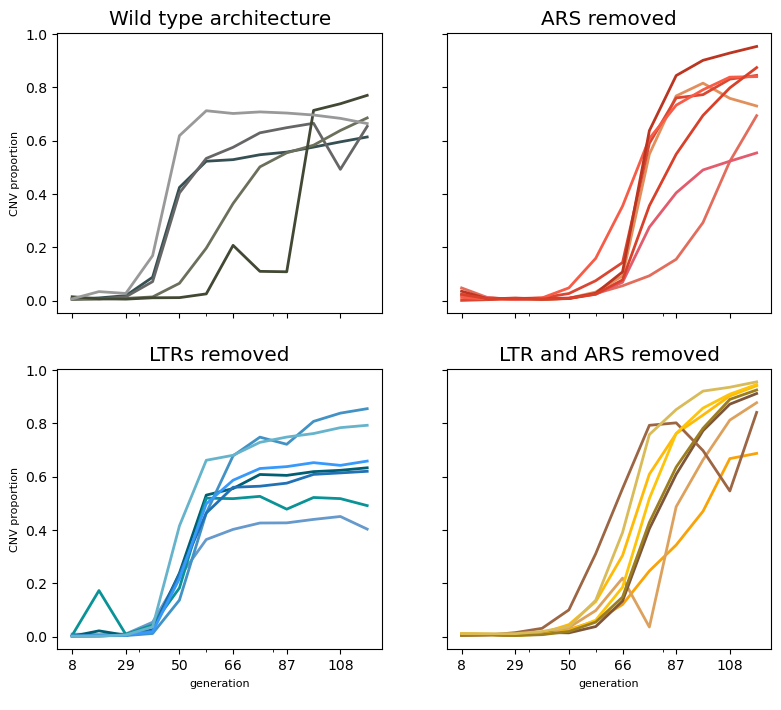

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharey=True, sharex=True)
lines = list(color_dict.keys())
font = 12
change_font(font)

for i in range(4):
    l = lines[i]
    d = read_empirical(l, clean=False)
    # r = read_empirical(l, clean=True)
    c = color_dict[l][0]
    # r.T.plot(ax=ax[i%2, i//2], color='k', legend=False, style='--', linewidth=1.5, markersize=4)
    d.T.plot(ax=ax[i%2, i//2], color=color_dict[l], legend = False, linewidth=2)
    # fig.legend(['imputation'], loc=(0.74,0.5))
    ax[i%2, i//2].set_title(label_dict[l])
    ax[i%2, i//2].set_xlabel('generation\n', fontsize=font-4)
    ax[i%2, i//2].set_ylabel('CNV proportion', fontsize=font-4)
fig.subplots_adjust(right=0.72)

# Finding MAPs

### MAPs using sbi's implementation (unbounded)

In [5]:
from sbi.inference import MCMCPosterior
import sbi.utils as utils

change_font(16)

# prior

prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,0.5,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

# Get Maximum A-Posteriori (MAP) using sbi's implementation
# Using MCMC posterior as DirectPosterior (default) sometimes fails to sample
# Returns MAP values and their posterior log-density (log_prob)
def get_map(posterior,x,line):
    posterior.set_default_x(x)
    print(f'Finding MAP for {x.name}') 
    potential_fn = posterior.potential_fn
    potential_fn.set_x(x)
    posterior_mcmc = MCMCPosterior(potential_fn, proposal = prior)
    map_value = posterior_mcmc.map(num_init_samples = 5000, num_iter = 200, show_progress_bars = False)
    return [line, posterior.log_prob(map_value).tolist()[0]] + map_value.tolist()

# Get MAPs for an entire genotype (line). 
# Each MAP is the average of several estimations (rep).
def get_maps(line, posterior, reps=1):
    obs = read_empirical(line, clean=True)
    maps = pd.DataFrame(index =  obs.index, columns = ['line', 'log_prob' ,'log(s_cnv)', 'log(m_cnv)', 'log(p_0)'])
    
    for i in range(len(obs)):
        all_res = pd.DataFrame(index = [i for i in range(reps)], columns = maps.columns)
        for r in range(reps):
            x = obs.iloc[i,:]
            labeled_map = get_map(posterior,x,line)
            print(labeled_map)
            all_res.iloc[r, :] = labeled_map
        all_res = all_res.groupby(['line']).mean()
        maps.iloc[i,:] = [line] + all_res.iloc[0,:].tolist()
        
    return maps

# Find MAPs for many genotypes
def create_all_maps(lines, posterior, reps):
    all_maps = get_maps(lines[0], posterior, reps = reps)
    for line in lines[1:]:
        all_maps = pd.concat([all_maps, get_maps(line, posterior, reps)])
    return all_maps

# lines = ['wt', 'ltr', 'ars', 'all']
# all_maps = create_all_maps(lines, posterior_chuong, reps=1)


### MAPs using grid-search in a bounded subspace

In [6]:
# Complexity is O(n^3) so using a large n may take a while

# Original prior
# prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
# prior_max = np.log10(np.array([1,0.5,1e-2]))

# Space that covers 85% of unbouded MAPs - most likely the region of true parameters
prior_min = np.log10(np.array([0.01,1e-7,1e-8]))
prior_max = np.log10(np.array([0.3,1e-3,1e-3]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

# Get grid of log posterior values for x
def get_grid(posterior, x, n=100):
    s = np.linspace(prior_min[0], prior_max[0], n)
    m = np.linspace(prior_min[1], prior_max[1], n)
    p = np.linspace(prior_min[2], prior_max[2], n)
    grd = np.array([[[[s_,m_,p_,0] for s_ in s] for m_ in m] for p_ in p]).reshape(n**3,4)
    x=torch.tensor(x.astype('float32'))
    posterior.set_default_x(x)
    grd[:,3] = posterior.log_prob(x=x,theta=torch.tensor(grd[:,0:3],dtype=torch.float32))
    prop = grd[grd[:,3].argmax()]
    return [prop[3],prop[0],prop[1],prop[2]]
    
# Toy example - small (n=50) grid
n = 50
all_maps_grd = pd.DataFrame(columns = ['line', 'log_prob' ,'log(s_cnv)', 'log(m_cnv)', 'log(p_0)'])
lines = ['wt', 'ltr', 'ars', 'all']
for line in lines:
    x = read_empirical(line)
    for i in range(len(x)):
        x_0 = x.iloc[i,:]
        print(x_0.name)
        all_maps_grd.loc[x_0.name,:] = [line] + get_grid(posterior_chuong, x_0, n=n)

all_maps_grd

gap1_1
gap1_2
gap1_3
gap1_4
gap1_5
gap1_ltr_1
gap1_ltr_3
gap1_ltr_4
gap1_ltr_5
gap1_ltr_6
gap1_ltr_7
gap1_ltr_8
gap1_ars_1
gap1_ars_3
gap1_ars_4
gap1_ars_5
gap1_ars_6
gap1_ars_7
gap1_ars_8
gap1_all_1
gap1_all_2
gap1_all_3
gap1_all_4
gap1_all_5
gap1_all_6
gap1_all_7
gap1_all_8


,line,log_prob,log(s_cnv),log(m_cnv),log(p_0)
gap1_1,wt,8.649907,-0.824332,-3.979592,-3.306122
gap1_2,wt,2.75821,-0.733896,-4.306122,-3.714286
gap1_3,wt,-4.902016,-0.975059,-4.142857,-3.510204
gap1_4,wt,8.96441,-0.884623,-5.612245,-5.55102
gap1_5,wt,8.323092,-0.522879,-5.204082,-4.938776
gap1_ltr_1,ltr,6.296932,-0.673605,-5.040816,-4.22449
gap1_ltr_3,ltr,-2.505955,-0.764041,-4.632653,-4.122449
gap1_ltr_4,ltr,-260.109772,-0.824332,-3.734694,-3.0
gap1_ltr_5,ltr,8.82283,-0.794187,-4.795918,-4.734694
gap1_ltr_6,ltr,3.656177,-0.764041,-4.714286,-4.122449


### Saved MAP values

In [5]:
all_maps_grd = pd.read_csv(f'maps/grid_all_maps_chuong_300pts_focus.csv', index_col=0)
lauer_maps_grd = pd.read_csv(f'maps/grid_all_maps_lauer_200pts_focus.csv', index_col=0)
all_maps_sbi = pd.read_csv('maps/sbi_all_maps_chuong.csv', index_col=0)
lauer_maps_sbi = pd.read_csv('maps/sbi_all_maps_lauer.csv', index_col=0)

maps_grd = pd.concat([all_maps_grd,lauer_maps_grd])
maps_sbi = pd.concat([all_maps_sbi, lauer_maps_sbi])

overall_maps = pd.read_csv('maps/overall_maps.csv', index_col=0)
overall_samples = pd.read_csv('maps/overall_posterior_samples.csv', index_col=0)

In [6]:
# Previous model's (a second unknown beneficial mutation) sbi MAPs 
chuong_prev_maps = pd.read_csv('maps/all_maps_prev_model.csv',index_col=0)
lauer_prev_maps = pd.read_csv('maps/lauer_maps_prev_model.csv',index_col=0)
prev_maps = pd.concat([chuong_prev_maps,lauer_prev_maps])

# Comparison of MAP values

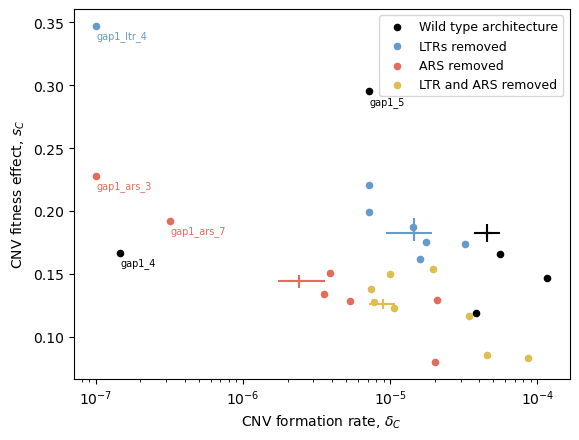

In [40]:
from seaborn import scatterplot

# Plot formation rate δc and fitness effect Sc for given MAPs
def plot_maps(ax, maps, lines, overall=False):
    extreme_s, extreme_m = np.log10(0.25), -6
    for c in lines:
        if overall:
            all_d = maps[maps['line'] == c]
            ax.scatter(x=10**all_d['log(m_cnv)'].astype('float64'), y=10**all_d['log(s_cnv)'].astype('float64'),
                     color=rep_colors[c], s = 60, marker='+')
            
            # Add HDIs
            samples = overall_samples[overall_samples['line']==c]
            s, m = 10**np.array(samples.iloc[:,1]), 10**np.array(samples.iloc[:,2])
            ax.hlines(float(10**all_d['log(s_cnv)'].astype('float64')), xmin=np.quantile(m,0.025), xmax=np.quantile(m,0.975), color=rep_colors[c])
            ax.vlines(float(10**all_d['log(m_cnv)'].astype('float64')), ymin=np.quantile(s,0.025), ymax=np.quantile(s,0.975), color=rep_colors[c])

        else:
            all_d = maps[maps['line'] == c]
            ax.scatter(x=10**all_d['log(m_cnv)'].astype('float64'), y=10**all_d['log(s_cnv)'].astype('float64'),
                     color=rep_colors[c], s = 20, label = f'{label_dict[c]}', marker='o')

        ax.set_xlabel('CNV formation rate, $δ_C$')
        ax.set_ylabel('CNV fitness effect, $s_C$')
        # ax.set_yscale('log')
        ax.set_xscale('log')
        ax.legend(fontsize = 9)
        for i in range(len(all_d)):
            cur = all_d.iloc[i,:]
            if cur[2] > extreme_s or cur[3] < extreme_m:
                ax.text(10**cur[3],10**cur[2]-0.01,cur.name, fontsize=7, color=rep_colors[c])

fig, ax = plt.subplots()
change_font(10)
        
# Only Chuong
chuong_lines = ['wt', 'ltr', 'ars', 'all']
maps = maps_sbi
plot_maps(ax, maps, chuong_lines)
plot_maps(ax, overall_maps, chuong_lines,overall=True)

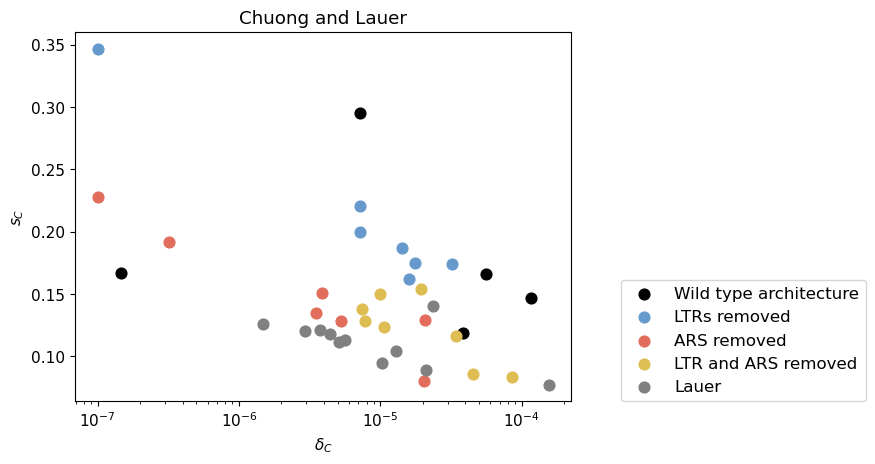

In [18]:
# With Lauer's MAPs
fig, ax = plt.subplots()
change_font(11)

lines = ['wt', 'ltr', 'ars', 'all', 'lauer']
maps = maps_sbi
plot_maps(ax, maps, lines, 'Chuong and Lauer')

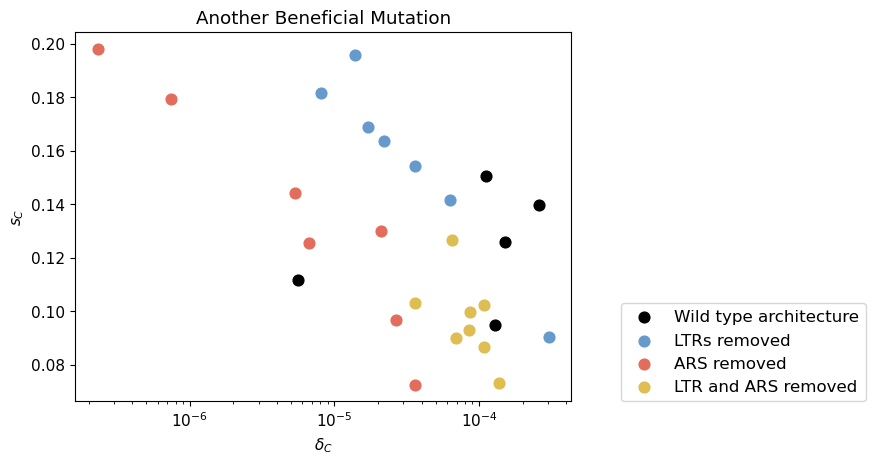

In [19]:
# Previous model
fig, ax = plt.subplots()
change_font(11)

chuong_lines = ['wt', 'ltr', 'ars', 'all']
maps = prev_maps
plot_maps(ax, maps, chuong_lines, 'Another Beneficial Mutation')

# Posterior Predictive Checks
### Simulating inferred parameters (MAP) in a WF model

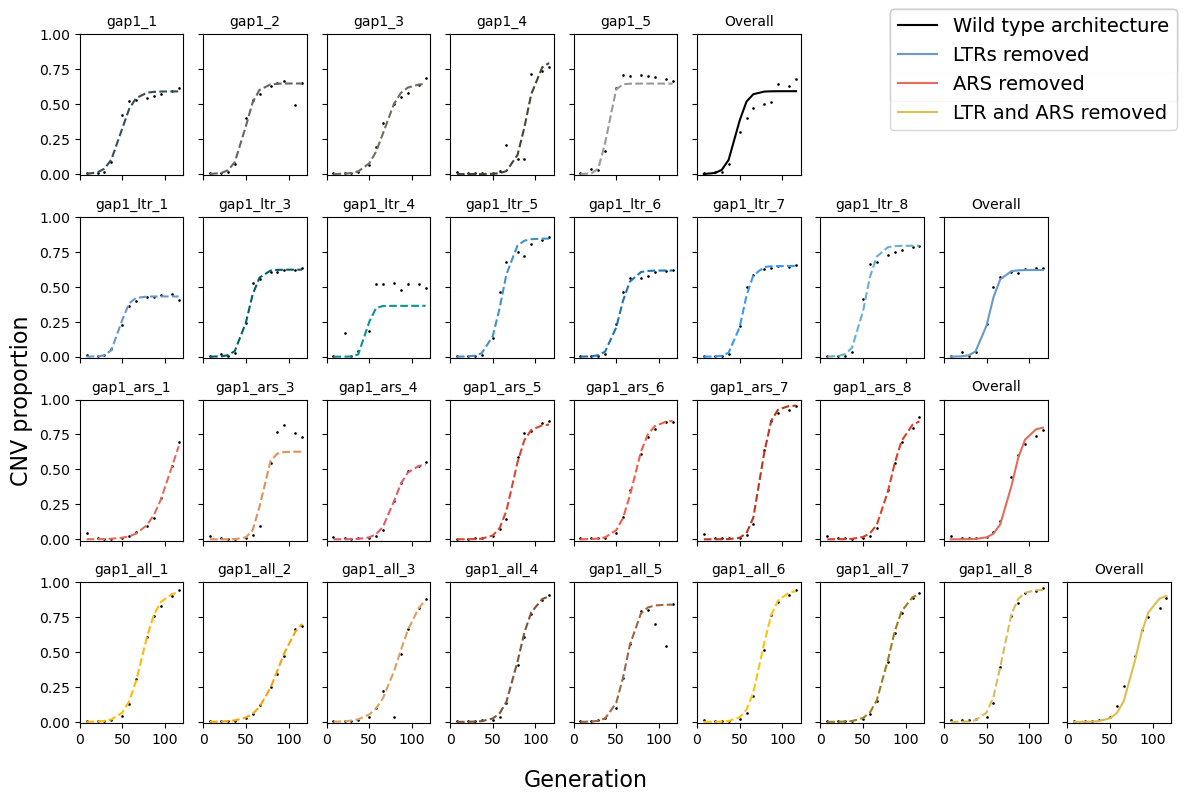

In [8]:
import pickle
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF
import torch

change_font(10)

# Simulation & model parameters
reps = 1
chuong_generation = pd.read_csv(f'Chuong_116_gens.txt', delimiter = ', ', engine='python')
chuong_generation = chuong_generation.columns.astype('int')
N = 3.3e8

# Simulator function - generates a posterior prediction given model parameters
def CNVsimulator(cnv_params, generation):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
        
    return states

# Plot posterior predictive checks of (approximate) MAP value
# MAP is obtained using sbi's method (Gradient Ascent)
# n_samples -> number of posterior sample to generate (to get a sense of posterior's variance)
def posterior_predictions(posterior, maps, lines, n_samples=0):
    fig, ax = plt.subplots(4,9, tight_layout=True, figsize=(12,8), sharex=True, sharey=True)
    for l in range(len(lines)):
        line = lines[l]
        # fig.suptitle(f'{label_dict[line]}')
        n = len(read_empirical(line))
        for i in range(n):
            axx = ax[l,i]
            color = color_dict[line][i]
            x = read_empirical(line,clean=False).iloc[i,:]
            generation = chuong_generation
            emp_x = read_empirical(line,clean=False).iloc[i,:]
            x = read_empirical(line,clean=False).iloc[i,:]
            axx.scatter(generation, emp_x, color = 'k', s=0.8) # data points are scattered

            axx.set_title(f'{x.name}', fontsize=10)
            # axx.set_ylabel(f'CNV proportion')
            # axx.set_xlabel(f'Generation')
            axx.set_ylim(-0.01)

            single_params = torch.tensor(maps.loc[x.name, 'log(s_cnv)':'log(p_0)']) # sbi params
            pred = CNVsimulator(single_params, generation).T
            axx.plot(generation, pred, color = color, linestyle='--', linewidth=1.5) # posterior prediction is plotted

            axx.set_yticks([0,0.25,0.5,0.75,1])
            axx.set_xticks([0,50,100])

            # Mark when CNV proportion is above 5%
            # axx.axvline(float(x[x>0.05].index[0]), color='k', linestyle='--')

            if n_samples != 0:
                potential_fn = posterior.potential_fn
                potential_fn.set_x(x)
                posterior_mcmc = MCMCPosterior(potential_fn, proposal = prior)
                samples = posterior_mcmc.set_default_x(x).sample((n_samples,))
                a=[]
                for j in range(n_samples):
                    axx.plot(generation, CNVsimulator(samples[j,:], generation).T, color = color, linewidth=2.8)
                    a.append(np.sqrt(((CNVsimulator(samples[j,:],generation)-np.array(x))**2).mean()))
                print(f'mean RMSE = {sum(a)/len(a)}')

        # Overall MAP
        axx = ax[l,n]
        axx.set_title('Overall', fontsize=10)
        # axx.set_ylabel(f'CNV proportion')
        # axx.set_xlabel(f'Generation')
        axx.set_ylim(-0.01)

        single_params = torch.tensor(overall_maps.loc[line, 'log(s_cnv)':]) # sbi params
        pred = CNVsimulator(single_params, generation).T
        axx.plot(generation, pred, color = rep_colors[line], linestyle='-', linewidth=1.5, label=label_dict[line]) # posterior prediction is plotted
        axx.scatter(generation, read_empirical(line).mean(), color='k', s=0.8)

        axx.set_yticks([0,0.25,0.5,0.75,1])
        axx.set_xticks([0,50,100])
    
        if n < 8:
            for k in range(n+1,9):
                ax[l,k].axis('off')
        fig.legend(loc='upper right', fontsize=14)
        fig.supxlabel('Generation', fontsize=16)
        fig.supylabel('CNV proportion', fontsize=16)

posterior_predictions(posterior_chuong,maps_sbi,lines=['wt','ltr','ars','all'])

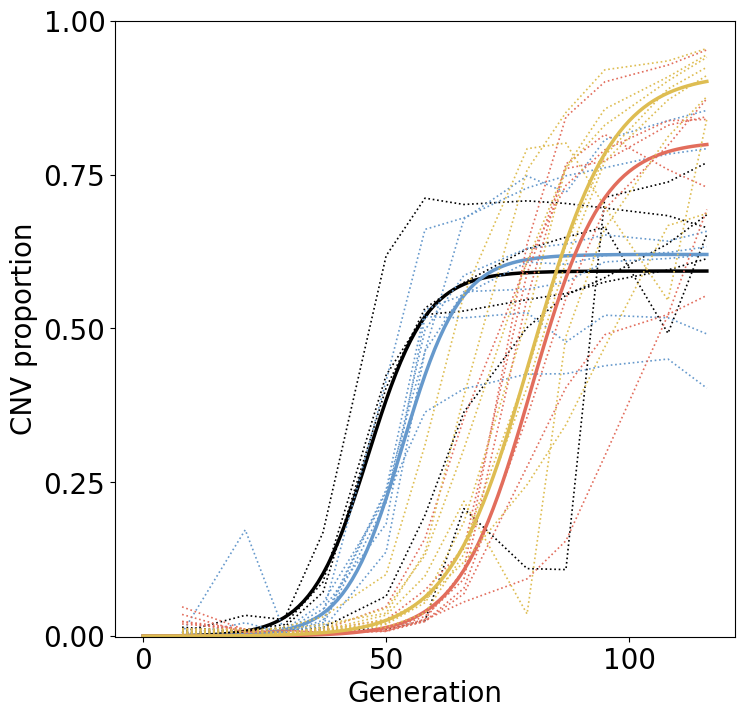

In [9]:
def posterior_predictions_main(posterior, maps, lines, n_samples=0):
    fig, ax = plt.subplots(figsize=(8,8))
    for l in range(len(lines)):
        line = lines[l]
        # fig.suptitle(f'{label_dict[line]}')
        n = len(read_empirical(line))
        for i in range(n):
            axx = ax
            color = rep_colors[line]
            x = read_empirical(line,clean=False).iloc[i,:]
            generation = chuong_generation
            emp_x = read_empirical(line,clean=False).iloc[i,:]
            x = read_empirical(line,clean=False).iloc[i,:]
            axx.plot(generation, emp_x, color = color, linewidth=1.2, linestyle='dotted') # data points are plotted
            # axx.scatter(generation, emp_x, color = color, s=2.5) # data points are scattered

            axx.set_ylabel(f'CNV proportion')
            axx.set_xlabel(f'Generation')
            axx.set_ylim(-0.001)
            axx.set_yticks([0,0.25,0.5,0.75,1])
            axx.set_xticks([0,50,100])

        # Overall MAP
        axx = ax
        full_gen = np.array([i for i in range(117)])
        single_params = torch.tensor(overall_maps.loc[line, 'log(s_cnv)':]) # sbi params
        pred = CNVsimulator(single_params, generation=full_gen).T
        axx.plot(full_gen, pred, color = color, linestyle='-', linewidth=2.5, label=label_dict[line]) # posterior prediction is plotted
        
change_font(20)
posterior_predictions_main(posterior_chuong,maps_sbi,lines=['wt','ltr','ars','all'])
